Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# SPARQL examples using the air-routes data set

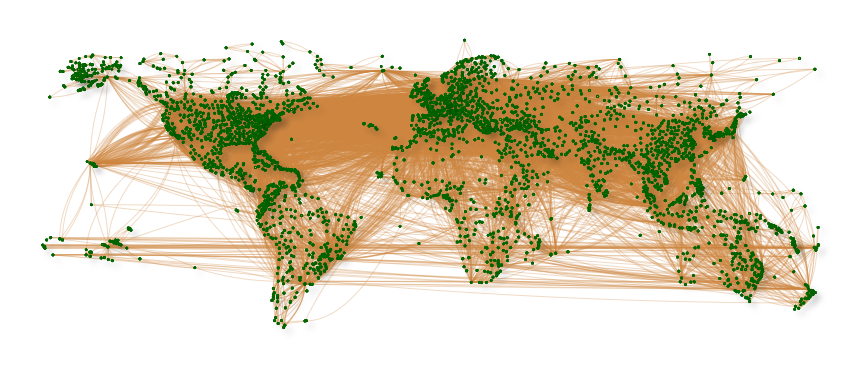

## Introduction

In this Notebook we are going to examine various SPARQL queries that explore an RDF graph that contains a model of the worldwide air route network. RDF triples are used to represent airports, countries, continents and their respective properties. There are additional triples that represent routes between airports and between the countries,continents and airports. The data set takes advantage of Named Graphs to represent the equivalent of edge properties that represent the distance between airports. This is further explained later in this notebook.

You can find the original data set in CSV form at the following GitHub repository: https://github.com/krlawrence/graph.   

The RDF version of the data set was created by converting the property graph CSV files into N-Quad format files using the tool located [here](https://github.com/aws/amazon-neptune-csv-to-rdf-converter).

### Let's check our configuration and Neptune cluster status
Before we start running any queries let's first of all make sure we are connected to Neptune and that the cluster is ready. Note that `%graph_notebook_config` will return the current configuration of your notebook. If, for example, you wanted to connect to a different Amazon Neptune endpoint you could create a cell with `%%graph_notebook_config` at the top, paste the results from running `%graph_notebook_config` into it, make the required edits and run the cell. Commands that start with a single percent sign are known as **_line magics_** and commands that start with two percent signs are known as **_cell magics_**.

In [ ]:
%graph_notebook_version

In [ ]:
%graph_notebook_config

In [ ]:
%status

### Using a different endpoint
You can change the endpoint that this notebook is connected to at any time using the `%graph_notebook_host` or `%%graph_notebook_config` commands. Edit and run the cell below whenever you need to change the endpoint you are connected to.

In [ ]:
%graph_notebook_host your-hostname-here

## Loading data
### Now let's load some RDF graph data.
The cell below makes it easy to load the air-routes data into your Neptune cluster in a form compatible with SPARQL (RDF graph) queries. When you run the cell you will be prompted to select a `Data model` and a `Data set`. Select `RDF` and `airports` respectively.  

**You only need to do this once**. If you have already loaded the data previously you do not need to load it again.

In [ ]:
%seed

## Seeing a visual representation of your query

The results of many SPARQL queries can be explored visually. When such queries are run you will see a `Graph` tab in the query results area alongside the other tabs. Specific visualization features will be explained  using examples throughout this notebook. There are a few requirements that must be followed if you want to have a visualization drawn.

The `SELECT` clause must be of one of two forms:
- `SELECT ?s ?p ?o`
- `SELECT ?subject ?predicate ?object`

You can use other variable names in your queries and in your `SELECT` clauses but only those using the above forms will cause a graph visualization, if appropriate, to be drawn. By default, if present, the `rdfs:label` triple value will be used to label graph components in the visualization.


### Query visualization hints

By default, a visualization will only include triple patterns where `?o` represents another triple resource. In other words, if `?o` is of type `uri` or `bnode` (blank node). All other `?o` binding types, such as `literal` (string, integer etc.), will be considered to be properties on the `?s` node.  These can be seen using the Details view under the `Graph` tab. If you want to also have literal values included in your visualization as vertices, which often is the case, you can specify a hint as shown below. 

`%%sparql --expand-all`

This tells the visualizer to include all `?s ?p ?o` results in the graph diagram. You will see this hint used throughout this notebook along with additional commentary. Feel free to experiment by running queries with and without the hint to see the differences to the visualization.

### Adjusting the visualization layout and other settings
You can further adjust many of the visualization settings using the two commands

- `%graph_notebook_vis_options`
- `%%graph_notebook_vis_options`

There are examples of how to use these settings and links to additional documentation at the bottom of this notebook.

## Getting help
You can get help at any time using the `--help` option as follows (the cell body needs at least one character in it for `--help` to work). 

`%%sparql --help`

Several of other the magic commands will accept `--help`. Each of the options described above also has a long form. For example `-d` can also be specified using `--display-options`. Run the cell below to see the full help text for the `%%sparql` command.

In [ ]:
%%sparql --help
x

## Example SPARQL Queries
The notebook cells that follow contain various queries that showcase both features of the SPARQL query language and features of the Amazon Neptune Notebook.

### Let's find out a bit about the RDF data in the graph
RDF graphs contain statements of the form (subject, predicate, object) known as triples. A triple can be used to associate a subject with a value or define a relationship between two subjects. The query below just returns 100 RDF triples so we can learn a bit about the structure of the graph. You can select the `Graph` tab to see the results in a visual form but they are not very interesting - yet! A few cells further down we will start to look at some queries that produce much more interesting visual results. The `Raw` tab shows the results as returned from the graph query engine in their raw form.

In [ ]:
%%sparql 

SELECT ?s ?p ?o {?s ?p ?o} LIMIT 100

We can easily discover the types used in the data set by looking at the triples with `rdf:type` predicates. The `DISTINCT` modifier in the query makes sure we only get one of each type back.

In [ ]:
%%sparql
PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT  DISTINCT ?t
WHERE {
    ?r rdf:type ?t 
}



### Exploring the air-routes graph
Now that we have a sense for the graph schema we can start to explore. First let's find out some information about the airports in the data set. The query below will find 20 airports and return their IATA codes. If you want to see more results just increase the value used for `LIMIT`.

The `PREFIX` definitions below are the main ones you will need when working with this data set. Most of the time you will only need a few of them for any given query but they are all listed here in case you need them later.

In [ ]:
%%sparql

PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX res:   <http://kelvinlawrence.net/air-routes/resource/>
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>
PREFIX geo:   <http://www.w3.org/2003/01/geo/wgs84_pos#>

SELECT ?s ?o
WHERE {
    ?s a class:Airport .
    ?s prop:code ?o
}
LIMIT 20


Now lets find out how many airports there are in this RDF graph.

In [ ]:
%%sparql
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT  (count(?a) as ?Total_Airports) 
WHERE {
    ?a a class:Airport
}



We can use a similar query to find out how many countries and sovereign territories there are in the data set.

In [ ]:
%%sparql
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT  (count(?c) as ?Total_Countries)
WHERE {
    ?c a class:Country
    
}



### We could also combine these queries into one
We can write a more generic query that takes advantage of the fact that many objects in the graph have an `rdf:type`. The query below will count all the different types of vertices in the graph.

In [ ]:
%%sparql
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT  ?type (count(?type) as ?count)
WHERE {
    ?r rdf:type ?type 
}
GROUP BY ?type
ORDER BY ?count


Finally to produce a nice tidy result with just the last part of the `rdf:type` IRI we can introduce a `BIND` modifier and do some string manipulation.

In [ ]:
%%sparql
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT  ?types (count(?types) as ?count)
WHERE {
    ?r rdf:type ?type .
    BIND (strafter(str(?type),str(class:)) as ?types)
}
GROUP BY ?types
ORDER BY ?count


### Let's explore the Cozumel (CZM) airport
Now we have an idea about the contents of the graph let's start to look a little deeper. First of all let's find out some information about the Cozumel (CZM) airport. The results of this query give further insight into the structure of the data set and the Internationalized Resource Identifiers (IRI) used in the graph. Initially lets just find all the RDF triples related to Cozumel. The `--expand-all` flag causes literal values (properties) to be included in the Graph diagram. You can experiment by removing it and re-running the query to see the differences. If you run the query without `--expand-all` enabled, you can still see the properties of the CZM vertex in the graph diagram by clicking on it and selecting the Details view.

In [ ]:
%%sparql --expand-all

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?s ?p ?o . 
    ?s prop:code "CZM" .
} LIMIT 50


### Finding all routes from Cozumel (CZM)
Try running the query below and clicking on the Graph tab to see the route map for flights from Cozumel. You will notice that the diagram just shows the resource identifiers for each airport. In the next cell we will change the query to achieve a nicer result.

In [ ]:
%%sparql

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>


SELECT ?s ?p ?o 
WHERE {
    ?s ?p ?o . 
    ?s prop:code "CZM" .
    ?s op:route ?o
} 
LIMIT 50

The query below produces a nice "star graph" picture showing the routes available from Cozumel and labels the destinations with the airport codes. Try running the query and selecting the Graph tab.

In [ ]:
%%sparql --expand-all

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?from prop:code "CZM" .
    ?from op:route ?to .
    ?to prop:code ?o .
    ?from prop:code ?s .
    BIND("route" AS ?p)
} 
LIMIT 50


If we are more interested in the properties of the Cozumel airport rather than the routes from it we can refine things a bit. The query below extracts only the properties (`prop:` predicates) for the Cozumel airport. This removes things such as the outgoing routes and the `rdf:type` from the results.

In [ ]:
%%sparql --expand-all

PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?s ?p ?o . 
    ?s prop:code "CZM" 
    FILTER (strstarts(str(?p),str(prop:)))
} 
LIMIT 50

### Using the details view
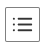

Another way to see all the properties associated with the Cozumel airport is to use the Details View. Run the query below, select the Graph tab, select the node in the graph and click on the details button (the one with three .- one above the other). 

In [ ]:
%%sparql

PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?s ?p ?o . 
    ?s prop:code "CZM" 
    FILTER (strstarts(str(?p),str(prop:)))
} 
LIMIT 50

This query finds all the airports in Mexico. Try clicking on different vertices in the Graph view and looking at the Details pane.

In [ ]:
%%sparql

PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?s ?p ?o . 
    ?s prop:country "MX" 
    FILTER (strstarts(str(?p),str(prop:)))
} 


The query below returns a table showing the cities where the airports with non-stop flights from Cozumel are located.

In [ ]:
%%sparql

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?from ?to 
WHERE {
    ?s ?p ?o . 
    ?s prop:code "CZM" .
    ?s op:route ?o .
    ?o prop:city ?to .
    ?s prop:city ?from
} 
LIMIT 50

### How long are the routes from Cozumel?
As mentioned at the top of this notebook, the air-routes RDF graph uses _Named Graphs_ to simulate edge properties. For any route between two airports the named graph position of the quad representing "Subject,Predicate,Object,Graph" or SPOG, will represent an edge resource. From that edge resource the route distance can be obtained. The query below takes advantage of these named graphs to calculate the distance of each route from Cozumel. The results are ordered by ascending distance.

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

SELECT ?from ?to ?distance 
WHERE {
  ?czm prop:code "CZM" .
  ?czm op:route ?dest .
  ?czm prop:code ?from.
  ?dest prop:code ?to.
  GRAPH ?route { ?czm op:route ?dest }
  ?route prop:dist ?distance }
ORDER BY ?distance

If we change the previous query just a little bit to return results in terms of `?s`, `?p` and `?o` we can generate a Graph diagram where the distances are shown as edge labels.

In [ ]:
%%sparql --expand-all
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

SELECT ?s ?p ?o WHERE {
  ?czm prop:code "CZM" .
  ?czm op:route ?dest .
  ?czm prop:code ?s.
  ?dest prop:code ?o.
  GRAPH ?route { ?czm op:route ?dest }
  ?route prop:dist ?p }
ORDER BY ?p

We can also use a `DESCRIBE` clause to find all of the triples related to Cozumel. You will see there is a mixture of routes and data about the airport.

In [ ]:
%%sparql

PREFIX res: <http://kelvinlawrence.net/air-routes/resource/>

DESCRIBE res:365


### Exploring countries
The query below finds the countries in the graph. You can use the Search box to find a country quickly after running the query.

In [ ]:
%%sparql

PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX res:   <http://kelvinlawrence.net/air-routes/resource/>
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT ?country ?code
WHERE {
    ?s ?p ?country .
    ?s a class:Country .
    ?s prop:desc ?country .
    ?s rdfs:label ?code
} 
ORDER BY ?country

### Exploring the schema for countries

The query below uses a `DESCRIBE` statement to find all triples related to the United Kingdom (UK). You will notice when you run the query that countries are connected to airports using `op:contains` predicates.

In [ ]:
%%sparql

PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

DESCRIBE ?s
WHERE {
    ?s ?p ?o .
    ?s a class:Country .
    ?s rdfs:label "UK"
}


### Finding all airports in the United Kingdom (UK)
The query below finds the vertex representing the United Kingdom in the graph and from there finds all of the airports connected to it by 'contains' relationships. The results are sorted in ascending order using the airport code.

In [ ]:
%%sparql

PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>
PREFIX class: <http://kelvinlawrence.net/air-routes/class/>

SELECT ?code ?desc
WHERE {
    ?s ?p ?o .
    ?s a class:Country .
    ?s rdfs:label "UK" .
    ?s op:contains ?o .
    ?o prop:desc ?desc .
    ?o prop:code ?code
}
ORDER BY ?code


### Which airports have the most routes?
Using the next query we can find out how many outgoing routes each airport has and create a group where the key is the airport code and the value is the number of routes. We then sort that group in descending order and return the top 20 results. Try changing the value of the `LIMIT` modifier to see more or less results. 

In [ ]:
%%sparql

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?airport (COUNT(?airport) as ?routes)
WHERE {
    ?s ?p ?o .
    ?s op:route ?o .
    ?s prop:code ?airport .
}
GROUP BY ?airport
ORDER BY desc(?routes)
LIMIT 20


### Let's find some routes from Austin (AUS) to Wellington (WLG)
The query below looks for up to 20 routes from Austin in the United States to Wellington in New Zealand that require two stops. We again take advantage of the named graphs to retrieve the distances for each route.

In [ ]:
%%sparql

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>
        
SELECT ?from ?d1 ?stop1 ?d2 ?stop2 ?d3 ?to ?total
WHERE {
    ?s  prop:code "AUS" .
    ?s  op:route ?s1 .
    ?s1 op:route ?s2 .
    ?s2 op:route ?s3 .
    ?s3 prop:code "WLG" .
    ?s  prop:code ?from .
    ?s1 prop:code ?stop1 .
    ?s2 prop:code ?stop2 .
    ?s3 prop:code ?to .
    GRAPH ?r1 { ?s op:route ?s1 }
    ?r1 prop:dist ?d1 
    GRAPH ?r2 { ?s1 op:route ?s2 }
    ?r2 prop:dist ?d2 
    GRAPH ?r3 { ?s2 op:route ?s3 }
    ?r3 prop:dist ?d3 
    BIND(?d1 + ?d2 + ?d3 as ?total)
   
}
ORDER BY ?total
LIMIT 20

### Where can I fly to from Santa Fe, New Mexico nonstop?
The query below finds the cities you can fly to nonstop from Santa Fe, New Mexico.

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

SELECT DISTINCT ?city
WHERE {
  ?aus prop:code "SAF" .
  ?aus op:route ?dest .
  ?dest prop:city ?city
}
LIMIT 2000
  

We can modify the previous query to answer the question "How many places can you get to from Santa Fe, New Mexico, with one stop but excluding the places you can get to non-stop?" The first part of the `WHERE` clause uses a property path to represent 'two hops'. The `MINUS` clause finds the places you can get to non-stop and removes them from the result set. Finally, the `FILTER` modifier guarantees that we do not include flights back to Santa Fe in the results. 

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

SELECT DISTINCT ?city
WHERE {
  ?saf prop:code "SAF" .
  ?saf op:route/op:route ?dest .
  ?dest prop:city ?city
  MINUS {
    ?a prop:code "SAF" .
    ?a op:route ?dest .
    ?dest prop:city ?city      
  }
  FILTER (?city != "Santa Fe")
}
ORDER BY ?city
LIMIT 2000

  

### What is the minimum number of stops needed to get from Austin (AUS) to Agra (AGR) ?
The next couple of cells include queries that look to see if you can get from Austin to Agra with 2 stops or if it takes at least three. An `ASK` clause is used to generate a result that will either be `true` or `false`. SPARQL Property Paths are again used to perform the tests. The first query asks whether two hops are sufficient.

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

ASK 
{
  ?aus prop:code "AUS" .
  ?aus op:route/op:route ?dest .
  ?dest prop:code ?target
  FILTER (?target = "AGR") 
}

If you ran the query in the previous cell you will know that we cannot get from AUS to AGR in two hops. So let's modify the query to ask "Can we get there in either two or three hops?".

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

ASK 
{
  ?aus prop:code "AUS" .
  ?aus (op:route/op:route) | (op:route/op:route/op:route) ?dest .
  ?dest prop:code ?target
  FILTER (?target = "AGR") 
}

Knowing we can get there in three hops, let's now find those routes.

In [ ]:
%%sparql
PREFIX prop: <http://kelvinlawrence.net/air-routes/datatypeProperty/> 
PREFIX op:   <http://kelvinlawrence.net/air-routes/objectProperty/> 

SELECT ?start ?stop1 ?stop2 ?end
WHERE
{
  ?aus  prop:code "AUS" .
  ?agr  prop:code "AGR" .
  ?aus  op:route  ?hop1 .
  ?hop1 op:route  ?hop2 .
  ?hop2 op:route  ?agr .
  ?aus  prop:code ?start .
  ?hop1 prop:code ?stop1 .
  ?hop2 prop:code ?stop2 .
  ?agr  prop:code ?end
}

### Flights from New Zealand to Australia
The query below looks for any flights originating in New Zealand and terminating in Australia. Click on the Graph tab to see the routes that were found. 

In [ ]:
%%sparql --expand-all
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?s ?p ?o
WHERE {
    ?from ?p ?to .
    ?from prop:country "NZ" .
    ?to prop:country "AU" .
    ?from op:route ?to .
    ?from prop:city ?s .
    ?to prop:city ?o
}
ORDER BY ?s ?o
LIMIT 300


### Examining a slightly larger result set visually
The query below retrieves routes from a selection of airports in the graph. If you click on the Graph tab you will see the vertices and edges. You may want to zoom in and out (using the scroll wheel on your mouse or the zoom gesture on your touchpad) and also pan the drawing by holding down the left mouse button while the pointer is not over a vertex or an edge and dragging. You can also move vertices around if they are overlapping by dragging them. Switching to the fullscreen view is also helpful when there re a lot of results to explore. To see even more results try adding a few more airport codes you are familiar with to the list inside the `FILTER`. You can also zoom the visualization in and out by clicking on the + and - icons.

**Clicking on the fullscreen icon in the Graph view will increase the size of the canvas.**
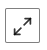


In [ ]:
%%sparql --expand-all
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?s ?p ?o
WHERE {
    ?from ?p ?to .
    ?from prop:code ?sc .
    ?from op:route ?to .
    ?from prop:city ?s .
    ?to prop:city ?o
    FILTER (?sc in ('SAF','LCG','BMI','CUU','FAR','FSD','MLI',
                    'MLM','AES','BVC','BGR','VXO','PBM','LRM','MGA'))
}
LIMIT 700


## Changing the visualization settings
The Amazon Neptune Notebooks use an open source library called [Vis.js](https://github.com/visjs) to assist with drawing the graph diagrams. Vis.js provides a rich set of customizable settings. The documentation for most of the visualization settings used in this notebook can be found [here](https://visjs.org/) and in particular the graph network drawing documentation can be found [here](https://visjs.github.io/vis-network/docs/network/).  

To see the current settings used by your notebook you can use the `%graph_notebook_vis_options` line magic command. Try running the cell below.  

To change any of these settings you can create a new cell and use `%%graph_notebook_vis_options` to change them (note the two percent signs indicating a cell magic).

These settings give you a lot of flexibility to customize your visualizations in whichever way you find most pleasing.

In [ ]:
%graph_notebook_vis_options

### Producing a hierarchical diagram
For some types of query using a hierarchical view is quite pleasing. Try running the cell below to change a few settings and then run the next cell that demonstrates the changes. There is another cell after that one you can use to restore the default settings.

In [ ]:
%%graph_notebook_vis_options
{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 70,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "hierarchicalRepulsion": {
      "centralGravity": 0
    },
    "minVelocity": 0.75,
    "solver": "hierarchicalRepulsion"
  },
  "layout": {
    "hierarchical": { 
      "enabled": true,
      "direction": "LR",
      "sortMethod": "directed",
      "edgeMinimization":false }
  }
}


Run the query in the cell below to see the results of changing to a hierarchical network view.

In [ ]:
%%sparql --expand-all

PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>
PREFIX op:    <http://kelvinlawrence.net/air-routes/objectProperty/>

SELECT ?s ?p ?o 
WHERE {
    ?from prop:code "CZM" .
    ?from op:route ?to .
    ?to prop:code ?o .
    ?from prop:code ?s .
    BIND("route" AS ?p)
} 
LIMIT 5

### Restore default settings
Running the cell below will return all visualization settings to their default values and display those settings.

In [ ]:
%graph_notebook_vis_options reset

## Variable substitution and reuse
The `--store-to` option can be used to capture query results in a Python variable.

In [ ]:
%%sparql --store-to res
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT (count(?s) AS ?texas)
WHERE {
    ?s prop:region "US-TX" 
}

In [ ]:
count = res['results']['bindings'][0]['texas']['value']
print(f'There are {count} airports in Texas')

A variable can also be substituted into a query.

In [ ]:
city = 'Los Angeles'

In [ ]:
%%sparql 
PREFIX prop:  <http://kelvinlawrence.net/air-routes/datatypeProperty/>

SELECT ?desc ?code
WHERE {
    ?s prop:city "${city}" .
    ?s prop:code ?code .
    ?s prop:desc ?desc
}

## Seeing more data
If you run the cell below, the notebook will use as much of the browser window (width wise) as it can.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))